Goal of project:

1.Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Note: for those first two steps don’t forget to normalize your features and randomize a selection for training and testing.

2.Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Estimate a bounding box for vehicles detected.

In [45]:
# import useful libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time

from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.metrics import recall_score,precision_score,f1_score

from PIL import Image

import os

# utilities libraries
import random

%matplotlib inline

#1. Feature extraction - use histogram of oriented gradients on images
#2. Split into train and test set
#3. Then train linear svm classifier

In [115]:
# create helper functions

# 1. Function that returns HOG Features

# params are : num_blocks, cells_per_block, orientation_bins
def get_hog_features(img,orient=9, pix_per_cell=8, cell_per_block=2,vis=True, feature_vec=True):
    
    if vis:
        #print("has visualization")
        features, hog_image = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell,pix_per_cell),
        cells_per_block = (cell_per_block,cell_per_block), transform_sqrt=False,
        visualise = True, feature_vector = feature_vec)
        
        return features,hog_image
    else:
        #print("no visualization")
        features = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell,pix_per_cell),
        cells_per_block = (cell_per_block,cell_per_block), transform_sqrt=False,
        visualise = False, feature_vector = feature_vec)
        
        return features

# 2. Function that iterates through images and calls a feature extractor
# feature_params can be a bunch of params
def get_features(img_list,feature_type,feature_params,num_samples = -99):
    
    features_list=[]
    
    #if feature_type == 'hog' and feature_params['vis'] == False:
    if feature_type == 'hog':
        for counter,img in enumerate(img_list):
            
                img = mpimg.imread(img)
                gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
                
                feature = get_hog_features(gray,**feature_params)
                features_list.append(feature)
                
                if counter == num_samples:
                    print("files processed: ",counter)
                    return features_list

        return features_list


In [73]:
# file utilities

def get_files(dir_path):
    files = []
    
    for file_name in os.listdir(dir_path):
        if file_name[-3:] =='png':
            files.append(dir_path+file_name)

    return files

def plot_sample_images(rand_nums,cur_img_files,cur_img_features):

    cur_files = cur_img_files
    cur_features = cur_img_features

    for counter,num in enumerate(rand_nums):
        index = num

        fig = plt.figure(figsize=(10, 10))

        # plot original image
        img = mpimg.imread(cur_files[index])
        ## num rows, num cols, plotnumber
        plt.subplot(len(rand_nums),3,1+counter*3)
        plt.imshow(img)

        # plot gray image
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        plt.subplot(len(rand_nums),3,2+counter*3)
        plt.imshow(gray, cmap='gray')

        # plot features
        plt.subplot(len(rand_nums),3,3+counter*3)
        plt.imshow(cur_features[index][1], cmap='gray')

In [120]:
# Main function call

# 1. Generate list of car vs non car - Done
dir_name = '/Users/davidwoo/Documents/Projects/kitt-playlabs/udacity/CarND-Vehicle-Detection-master/data/'

folder_name_noncar = 'non-vehicles/GTI/'
folder_name_car = 'vehicles/KITTI_extracted/'


car_files = get_files(dir_name + folder_name_car)
noncar_files = get_files(dir_name + folder_name_noncar)

num_samples = -99

print("num car pictures ",len(car_files))
print("num car pictures ",len(noncar_files))
    

# get files in 

# 2. Set params of hog features
bog_params = {'orient' : 9,
'pix_per_cell' : 8,
'cell_per_block' : 2,
'vis':False}

# 3. Generate list of features for car vs non car
car_features= get_features(car_files,'hog',bog_params,num_samples)
non_car_features= get_features(noncar_files,'hog',bog_params,num_samples)


('num car pictures ', 5966)
('num car pictures ', 3900)


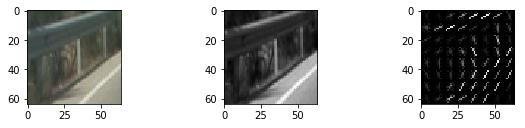

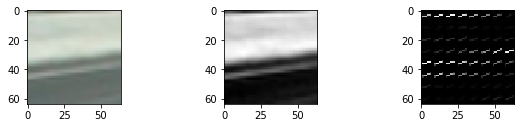

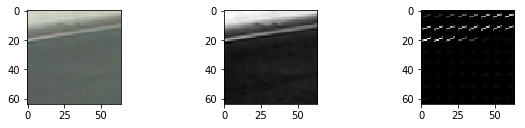

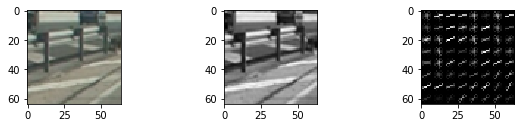

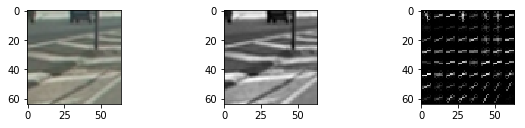

In [111]:
rand_nums = random.sample(range(0,len(car_features)),5)

cur_files = noncar_files
cur_features = non_car_features

plot_sample_images(rand_nums,cur_files,cur_features)

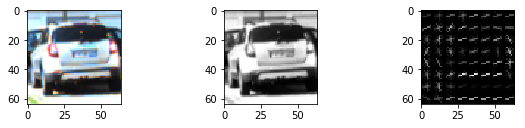

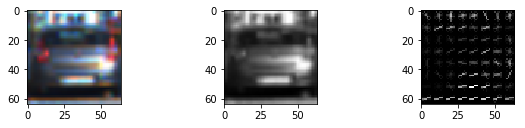

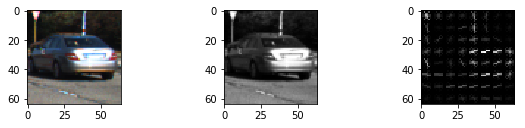

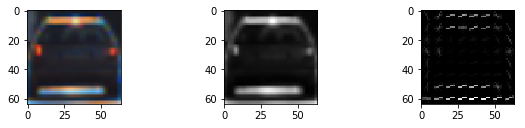

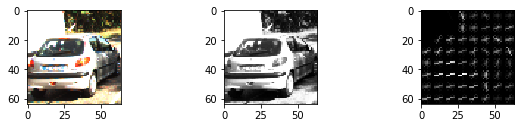

In [112]:
rand_nums = random.sample(range(0,len(car_features)),5)

cur_files = car_files
cur_features = car_features

plot_sample_images(rand_nums,cur_files,cur_features)

TypeError: Invalid dimensions for image data

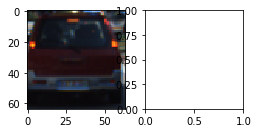

In [121]:
# want to be able to visualize this. i think it's not discriminate enough between the two

index = random.sample(range(0,len(car_features)),5)[0]
plt.subplot(2,2,1)
# get one car image and plot on a graph. do a regular bar chart

plt_cols = 3
plt_rows = 2

# car 
## plot image
plt.subplot(plt_rows,plt_cols,1)
img = mpimg.imread(car_files[index])
plt.imshow(img)

## plot img features
plt.subplot(plt_rows,plt_cols,2)
plt.imshow(car_features[index][1], cmap='gray')
        
## plot img features
plt.subplot(plt_rows,plt_cols,3)
car_img_features = car_features[index][0]
y_pos = np.arange(len(car_img_features))
plt.bar(y_pos-0.01,car_img_features,color='b',align='center')

# noncar 
## plot image
plt.subplot(plt_rows,plt_cols,4)
img = mpimg.imread(noncar_files[index])
plt.imshow(img)

## plot img features
plt.subplot(plt_rows,plt_cols,5)
plt.imshow(non_car_features[index][1], cmap='gray')

## plot img features
plt.subplot(plt_rows,plt_cols,6)
non_car_img_features = non_car_features[index][0]
y_pos = np.arange(len(non_car_img_features))
plt.bar(y_pos+0.01,non_car_img_features,color='r',align='center')

#print(img_features)


In [122]:
# 4. normalize feature set
car_features_np = np.array(car_features)
print("num car pictures and features: ",car_features_np.shape)

non_car_features_np = np.array(non_car_features)
print("num car pictures and features: ",non_car_features_np.shape)

##stack car and noncar features
combined_features_np = np.vstack([car_features_np,non_car_features_np])
print("num combined pictures and features: ",combined_features_np.shape)
print(np.min(combined_features_np),np.max(combined_features_np),np.mean(combined_features_np))

## scaling similar to model
scaler = StandardScaler().fit(combined_features_np)
combined_features_np_scaled = scaler.transform(combined_features_np)
print("num combined pictures and features after scaling: ",combined_features_np_scaled.shape)
## seems to center at zero
print(np.min(combined_features_np_scaled),np.max(combined_features_np_scaled),np.mean(combined_features_np_scaled))

# 5. create labels - nicely done here.
## first x = car , botton x = noncar
labels_car = np.ones(car_features_np.shape[0])
labels_non_car = np.zeros(non_car_features_np.shape[0])
labels = np.hstack([labels_car,labels_non_car])
print(labels.shape)


# 6. split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    combined_features_np, labels, test_size=0.33, random_state=42)
print("train set x, y:",len(X_train),len(y_train))
print("test set x, y:",len(X_test),len(y_test))

# 7. train svm model
# initial SVM with params
# specify kernel ( linear, non linear), narrow or wide margin, number of samples of points
clf = LinearSVC()
clf.fit(X_train,y_train)
# this prints accuray. so 13% which seems low
print("mean accuracy",clf.score(X_test,y_test))

print("recall score" ,recall_score(y_test,clf.predict(X_test)))
print("precision score" ,precision_score(y_test,clf.predict(X_test)))
# this is a weighted average of the recall and precision so should be in between
print("f1score score" ,f1_score(y_test,clf.predict(X_test)))

# 8. output results

('num car pictures and features: ', (5966, 1764))
('num car pictures and features: ', (3900, 1764))
('num combined pictures and features: ', (9866, 1764))
(0.0, 0.99307341921842984, 0.027771280165910132)
('num combined pictures and features after scaling: ', (9866, 1764))
(-1.1620160604758429, 54.389593858253313, -2.9705933346931014e-18)
(9866,)
('train set x, y:', 6610, 6610)
('test set x, y:', 3256, 3256)
('mean accuracy', 0.9867936117936118)
('recall score', 0.98896136477671848)
('precision score', 0.98945783132530118)
('f1score score', 0.98920953575909654)
